# SimuPOP autopsy
I will pick up from where I left last time around. I'm copying key functions over over from 150319_qingyun_collaboration.ipynb to avoid having to save that notebook and loosing back compatibility with my Mac.

## Aims
1. Save intermediate results of simulations.
2. Add infinite sites.
3. Add infinite alleles.
4. Add subpopulations.
5. Add fitness effects.

In [1]:
#Set up the notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as ss
import simuPOP as sim
from simuPOP.plotter import VarPlotter
from sklearn import utils as sku

%matplotlib inline

In [2]:
#Define functions
def logistic(x, K, r, N0):
    """Generate a logistic curve

    Input
    -------
    x: 1D array
    K: carrying capacity
    r: Growth rate
    N0: starting population
    
    Output
    -------
    Calculates the population at time x given the parameters using a simple logistic model
    adapted from wikipedia: http://en.wikipedia.org/wiki/Logistic_function 
    
    Notes
    -------
    Made to be used with scipy.optimize.curve_fit 
    """
    return (K*N0*np.exp(r*x))/(K+N0*(np.exp(r*x)-1))

def exp_decay(x, N, k):
    """Calculate the exponential decay of a number.

    Input
    -------
    x: 1D array
    N: Starting population
    k: exponential decay constant

    Output
    -------
    1D array

    Notes
    -------
    Adapted form: http://en.wikipedia.org/wiki/Exponential_decay
    """
    return N*np.exp(-x/k)

def demo_dynamic(g, N0, r, K, k, point_A, point_S, r_=None, K_=None):
    """Demographic function for Qingyun's paper
    
    INPUT:
    ------
    g: number of generations to be conisdered
    N0: starting population (logistic)
    r: growth rate (logistic)
    K: carrying capacity (logistic)
    k: decay rate (exponential decay)
    point_A: generation of effective treatment
    point_S: generation of sampling
    r_: growth rate of re-growth
    K_: carrying capacity of re-growth
    
    OUTPUT:
    -------
    Population size dynamics
    
    NOTES:
    ------
    Modelled on:
    http://simupop.sourceforge.net/manual_release/build/userGuide_ch8_sec2.html
    therefore expected to be called as:
        demo_func = demo_dynamic(101, 100., np.log(2), 100000., 15., 30, 60)
        demo_func(70) : population size at generation 70

    """
    
    if r_==None: r_ = r 
    if K_==None: K_ = K
    
    _unperturbed = logistic(np.arange(g), K, r, N0)
    _decayed = exp_decay(np.arange(g), _unperturbed[point_A], k)
    _regrown = logistic(np.arange(g), K_, r_, _decayed[point_S-point_A]*0.001) #1/1000 dilution
    
    _overall = np.concatenate((_unperturbed[:point_A], _decayed[:point_S-point_A], _regrown))
    
    def snipett(gen):
        return _overall[gen]
    
    return snipett

## Demographic model

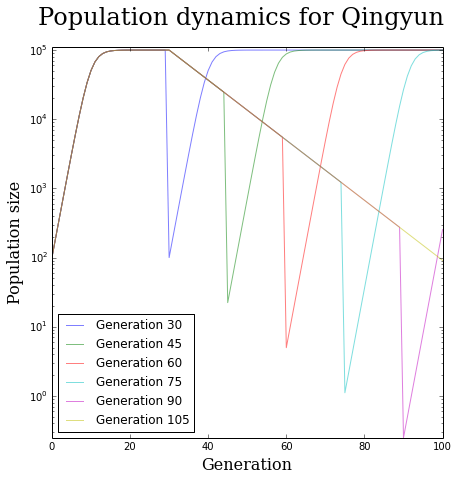

In [3]:
#Roadtest the demographic
plt.figure('Q_demographic', figsize=(7,7))

for sampling in range(30,110,15):
    demo_func = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, sampling) #Have to assume a high enough N0 (rare alleles)
    plt.plot(np.arange(101),demo_func(np.arange(101)), label='Generation %s' %sampling, alpha=0.5)

plt.xlabel('Generation', size=16, family='serif')
plt.ylabel('Population size', size=16, family='serif')
plt.yscale('log')
plt.legend(loc='lower left')
plt.ylim(0,110000)
plt.suptitle('Population dynamics for Qingyun', size=24, family='serif')

## Storing intermediate results

There appear to be two ways of doing this. The simplest case relies on the <strong>PyExec</strong> command and it allows coded statistics to be appended into a list.

For example we calculate the allele frequency during each generation of the evolution (_postOps=[sim.Stat(alleleFreq=0)...]_) and record the output into a list which we have generated at the beginning of the simulation (_initOps=[sim.PyExec('traj=[]')...]_). The data are stored in the variables dictionary using the replicate index as key ".dvars(_rep_)".

A coded example of this can be <a href="http://simupop.sourceforge.net/Cookbook/FollowFreqTrajectory">found here</a>.

PyExec may actually be most suitable for my purpuses as it does not output the function result to the StdOut but rather stores it in a variable.

In [4]:
simu = sim.Simulator(sim.Population(100, loci=1),
    rep=2)
simu.evolve(
    initOps=[
        sim.InitSex(),
        sim.InitGenotype(freq=[0.2, 0.8]),
        sim.PyExec('traj=[]')
    ],
    matingScheme=sim.RandomMating(),
    postOps=[
        sim.Stat(alleleFreq=0),
        sim.PyExec('traj.append(alleleFreq[0][1])')
    ],
    gen=5
)
# print Trajectory
print(', '.join(['%.3f' % x for x in simu.dvars(0).traj]))

0.835, 0.865, 0.890, 0.905, 0.880


In [5]:
#Post festum access to the stats:
print 'Replicate 1: ', simu.dvars(0).traj #replicate 1
print 'Replicate 2: ', simu.dvars(1).traj #replicate 2

Replicate 1:  [0.835, 0.865, 0.89, 0.905, 0.88]
Replicate 2:  [0.795, 0.795, 0.795, 0.78, 0.78]


## Add demography
Introduce the demographic model and use a low frequency variant for simulation.

    Follow the population at generation 36, 48 and 60.
    
Run the simulations, then comment out the cells, save the outcomes and next time import them from csv.

In [56]:
#Define the population
pop = sim.Population(size=100, loci=1)

demo_func = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, 36)

simu2 = sim.Simulator(pop,rep=100)
simu2.evolve(
    initOps=[
        sim.InitSex(),
        sim.InitGenotype(freq=[0.95,0.05]),
        sim.PyExec('traj=[]')
    ],
    matingScheme=sim.RandomSelection(subPopSize=demo_func),
    postOps=[
        sim.Stat(alleleFreq=0),
        sim.PyExec('traj.append(alleleFreq[0][1])', step=10),
    ],
    gen=101
)

(101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L)

In [11]:
#Define the population
pop = sim.Population(size=100, loci=1)

demo_func1 = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, 48)

simu3 = sim.Simulator(pop,rep=100)
simu3.evolve(
    initOps=[
        sim.InitSex(),
        sim.InitGenotype(freq=[0.95,0.05]),
        sim.PyExec('traj=[]')
    ],
    matingScheme=sim.RandomSelection(subPopSize=demo_func1),
    postOps=[
        sim.Stat(alleleFreq=0),
        sim.PyExec('traj.append(alleleFreq[0][1])', step=10),
    ],
    gen=101
)

(101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L)

In [50]:
#Define the population
pop = sim.Population(size=100, loci=1)

demo_func2 = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, 60)

simu4 = sim.Simulator(pop,rep=100)
simu4.evolve(
    initOps=[
        sim.InitSex(),
        sim.InitGenotype(freq=[0.95,0.05]),
        sim.PyExec('traj=[]')
    ],
    matingScheme=sim.RandomSelection(subPopSize=demo_func2),
    postOps=[
        sim.Stat(alleleFreq=0),
        sim.PyExec('traj.append(alleleFreq[0][1])', step=10),
    ],
    gen=101
)

(101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L,
 101L)

In [3]:
def confidence_interval(data, CI=0.95, normal=False):
        """Calculate the confidence interval for a dataset 
        which is distribution blind.

        Can be used in the case of a normal distribution expectation.

        INPUT:
        ------
        data: 1D np.array
        CI: float < 1.0, confidence interval of interest
            expects 0.95 for 95% CI, 0.9 for 90% CI...
        normal: bool, determine CI based on normal distribution.


        OUTPUT:
        -------
        lower_CI, upper_CI: float


        NOTES:
        ------
        Designed to be used in conjuncion with bootstrapping

        Adapted from:
        http://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals
        http://adventuresinpython.blogspot.ch/2012/12/confidence-intervals-in-python.html

        """
        
        _CI = (1.+CI)/2.
        
        _lower_CI = sorted(data)[int((1.-_CI)*len(data))]
        _upper_CI = sorted(data)[int((_CI)*len(data))]

        _R = (_lower_CI, _upper_CI)

        if normal!=False:
            _n, _min_max, _mean, _var, _skew, _kurt = ss.describe(data)
            _std=np.sqrt(_var)

            _R = ss.norm.interval(1-_CI,loc=_mean,scale=_std)

        return _R

In [6]:
##Turn data into a numpy array
#evolution_experiment = np.array([simu2.dvars(x).traj for x in range(100)], dtype=float)
#evolution_experiment1 = np.array([simu3.dvars(x).traj for x in range(100)], dtype=float)
#evolution_experiment2 = np.array([simu4.dvars(x).traj for x in range(100)], dtype=float)

#Import data from csv files
evolution_experiment = np.loadtxt('../../150306_Qingyun_serial/additional_data/150617_simuPOP_sc1_36.csv', delimiter=',')
evolution_experiment1 = np.loadtxt('../../150306_Qingyun_serial/additional_data/150617_simuPOP_sc1_48.csv', delimiter=',')
evolution_experiment2 = np.loadtxt('../../150306_Qingyun_serial/additional_data/150617_simuPOP_sc1_60.csv', delimiter=',')

#Make a callable demographic model
demo_func = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, 36) #Have to assume a high enough N0 (rare alleles)
demo_func1 = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, 48) #Have to assume a high enough N0 (rare alleles)
demo_func2 = demo_dynamic(101, 100., np.log(2), 100000., 10., 30, 60) #Have to assume a high enough N0 (rare alleles)

#Calculate condifence intervals of the mean
simu2_CI = []
simu2_mean = []
for ind,val in enumerate(evolution_experiment.T):
        val = val[val>0]
        simu2_CI.append(confidence_interval([np.mean(sku.resample(val)) for i in range(1000)]))
        simu2_mean.append(np.mean(val))

#Calculate condifence intervals of the mean
simu3_CI = []
simu3_mean = []
for ind,val in enumerate(evolution_experiment1.T):
        val = val[val>0]
        simu3_CI.append(confidence_interval([np.mean(sku.resample(val)) for i in range(1000)]))
        simu3_mean.append(np.mean(val))


#Calculate condifence intervals of the mean
simu4_CI = []
simu4_mean = []
for ind,val in enumerate(evolution_experiment2.T):
        val = val[val>0]
        simu4_CI.append(confidence_interval([np.mean(sku.resample(val)) for i in range(1000)]))
        simu4_mean.append(np.mean(val))

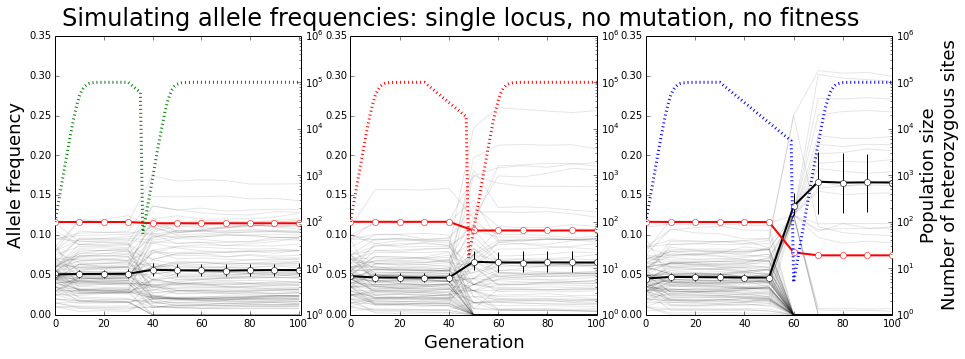

In [30]:
#Make the plot
plt.figure('Dynamic', figsize=(15,5))
plt.subplot(131)
plt.plot(np.arange(0,110,10),evolution_experiment.T,'k-',alpha=0.1)
plt.plot(np.arange(0,110,10),simu2_mean,'ko', ls='solid',mfc='white', lw=2)
plt.vlines(np.arange(0,110,10), [cl[0] for cl in simu2_CI], [cl[1] for cl in simu2_CI],color='black')
plt.ylabel('Allele frequency',size=18)
plt.xlim(0,101)
plt.ylim(0,0.35)
plt.twinx()
plt.plot(np.arange(0,110,10),[len(x[x>0]) for x in evolution_experiment.T],'ro', ls='solid',mfc='white',mec='red', lw=2)
plt.plot(np.arange(101),demo_func(np.arange(101)), 'g:', label='Demobraphic model', lw=3)
plt.yscale('log')
plt.ylim(1,1e6)
plt.xlim(0,101)
plt.subplot(132)
plt.plot(np.arange(0,110,10),evolution_experiment1.T,'k-',alpha=0.1)
plt.plot(np.arange(0,110,10),simu3_mean,'ko', ls='solid',mfc='white', lw=2)
plt.vlines(np.arange(0,110,10), [cl[0] for cl in simu3_CI], [cl[1] for cl in simu3_CI],color='black')
plt.xlabel('Generation',size=18)
plt.xlim(0,101)
plt.ylim(0,0.35)
plt.twinx()
plt.plot(np.arange(0,110,10),[len(x[x>0]) for x in evolution_experiment1.T],'ro', ls='solid',mfc='white',mec='red', lw=2)
plt.plot(np.arange(101),demo_func1(np.arange(101)), 'r:', label='Demobraphic model', lw=3)
plt.yscale('log')
plt.ylim(1,1e6)
plt.subplot(133)
plt.plot(np.arange(0,110,10),evolution_experiment2.T,'k-',alpha=0.1)
plt.plot(np.arange(0,110,10),simu4_mean,'ko', ls='solid',mfc='white', lw=2)
plt.vlines(np.arange(0,110,10), [cl[0] for cl in simu4_CI], [cl[1] for cl in simu4_CI],color='black')
plt.xlim(0,101)
plt.ylim(0,0.35)
plt.twinx()
plt.plot(np.arange(0,110,10),[len(x[x>0]) for x in evolution_experiment2.T],'ro', ls='solid',mfc='white',mec='red', lw=2)
plt.plot(np.arange(101),demo_func2(np.arange(101)), 'b:', label='Demobraphic model', lw=3)
plt.yscale('log')
plt.ylim(1,1e6)
plt.xlabel('Generation',size=18)
plt.ylabel('Population size\nNumber of heterozygous sites',size=18)
plt.suptitle('Simulating allele frequencies: single locus, no mutation, no fitness',size=24)
plt.show()

What about the number of Het sites in this case?

## Multiple loci
Use the initial number of loci and frequencies for patient 1 to simulate.

Here are the stats for p2:
>Total loci: 26 | T1 loci: 6 | T2 loci: 14 | T3 loci: 8 | T4 loci: 7

So first let's see how to set up, run and store the result for multiple loci:

In [20]:
simu = sim.Simulator(sim.Population(100, loci=[10]),
    rep=2)
simu.evolve(
    initOps=[
        sim.InitSex(),
        sim.InitGenotype(freq=[0.99, 0.01]),
        sim.PyExec('traj=[]')
    ],
    matingScheme=sim.RandomMating(),
    postOps=[
        sim.Stat(alleleFreq=sim.ALL_AVAIL),
        sim.PyExec('[traj.append(alleleFreq[x][1]) for x in range(10)]')
    ],
    gen=5
)
# print Trajectory
for g in range(5):
    _start = 10*g
    print(', '.join(['%.3f' % x for x in simu.dvars(0).traj][_start:_start+10]))

0.015, 0.015, 0.005, 0.005, 0.020, 0.010, 0.020, 0.020, 0.005, 0.010
0.015, 0.005, 0.000, 0.005, 0.020, 0.025, 0.020, 0.010, 0.015, 0.010
0.005, 0.005, 0.000, 0.000, 0.025, 0.035, 0.010, 0.010, 0.030, 0.000
0.010, 0.005, 0.000, 0.000, 0.020, 0.045, 0.010, 0.010, 0.035, 0.000
0.005, 0.015, 0.000, 0.000, 0.020, 0.035, 0.005, 0.010, 0.015, 0.000


The result is ok, but it needs to be reshaped.

## Add mutation rate
Perhaps simplify simulation until you get a better hold of it. Choose between infinite alleles, k-alleles and infinite sites.